In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,5)})

# I. Preprocessing
## I.1 Définition d'une stratégie

In [7]:
def apply_strategy(stock,wind_width = 3):
    stock["up"] = stock["Open"].rolling(window=wind_width, center = True).max()
    stock["low"] = stock["Open"].rolling(window=wind_width, center = True).min()
    
    stock["vente"] = stock["up"]-stock["Open"]
    stock["vente"] = stock["vente"].apply(lambda x : x==0)

    stock["achat"] = stock["low"]-stock["Open"]
    stock["achat"] = stock["achat"].apply(lambda x : x==0)
    l=[]
    i=0
    last_action = "achat"
    amount_ac = 0
    while not stock.iloc[i]["achat"]: 
        l.append([0,0,"Pas de prise de position",1,0])
        i+=1
    amount_ac = stock.iloc[i]["Open"]
    amount =0
    p_cent = 1
    l.append([-1, amount_ac,last_action,1,0])
    i+=1
    while i !=len(stock):
        if last_action == "achat" and stock.iloc[i]["vente"] : 
            last_action = "vente"
            p_cent = stock.iloc[i]["Open"]*p_cent/amount_ac
            amount+=stock.iloc[i]["Open"]-amount_ac
            l.append([1,amount_ac,last_action,p_cent,amount])
        elif last_action == "vente" and stock.iloc[i]["achat"]:
            amount_ac = stock.iloc[i]["Open"]
            last_action = "achat"
            l.append([-1,stock.iloc[i]["Open"],last_action,p_cent,amount])
        elif last_action=="achat" : l.append([0,0,"holding",p_cent,amount])
        elif last_action=="vente" : l.append([0,0,"waiting",p_cent,amount])
        i+=1
    
    j=1
    if last_action != "vente":
        while l[-j][2]  !="vente" :j+=1
        for k in range(1,j):
            l[-k]= [0,l[-j][1],"End of strat",l[-j][3],l[-j][4]]
    assert len(l) == len(stock), "Probleme de dim"
    assert (l[-1][2] == "End of strat" or l[-1][2] =="waiting" or l[-1][2] =="vente") , "Achat final"
    #assert l[-1][-1]>0 , "Stratégie perdante"
    
    stock["strat"] = np.array(l)[:,0]
    stock["strat"]=stock["strat"].astype("float64")
    
    stock["doing"] = np.array(l)[:,2]
    
    stock["p_strat"] = np.array(l)[:,1]
    stock["p_strat"]=stock["p_strat"].astype("float64")
    
    stock["pc_strat"] = np.array(l)[:,4]
    stock["pc_strat"]=stock["pc_strat"].astype("float64")
    stock["amount"] = np.array(l)[:,4]
    stock["amount"]=stock["amount"].astype("float64")
    
    return(stock)
            

In [8]:
stock_name = "OR.PA"

stock = pd.DataFrame(yf.Ticker(stock_name).history(period="max"))
stock = stock["2016"]
stock = apply_strategy(stock)

Vérifions visuellement si notre stratégie fait sens :

<AxesSubplot:xlabel='Date'>

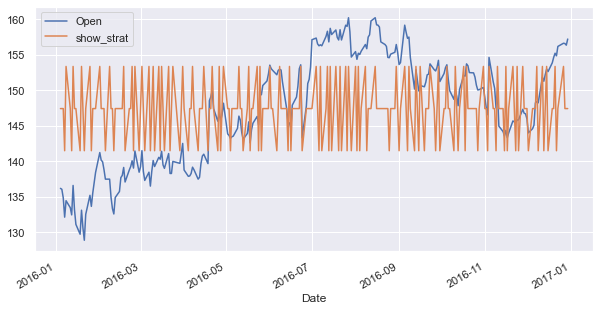

In [5]:
stock["show_strat"] = stock["strat"]*stock["Open"].var()/10+stock["Open"].mean()
stock[["Open", "show_strat"]].plot()

Cela semble être le cas.

## I.2 Optimisation de la stratégie

Le seuil de détéction de notre stratégie de trading repose sur la largeur de la fenêtre sur laquelle est effectuée la moyenne qui, comparée à la valeur à l'instant t, permet de décider quelle action doit être prise.

Essayons de déterminer quelle largeur maximise le profit.

Pour ce faire, nous allons appliquer la stratégie sur un ensemble d'entreprise pour éviter de l'optimiser sur une action particulière.

Pour chaque entreprise, nous allons calculer la moyenne sur 10 ans  des rendements annuel de la stratégie (de 2010 à 2020) en faisant varier la largeur de la fenêtre de 1 à 9. 

In [177]:
stocks = {"L'Oréal Paris" : "OR.PA", "Google" : "GOOGL", "Crédit agricole" : "ACA.PA", "CAC 40":"^FCHI", "APPLE": "AAPL", "Société Générale":"GLE.PA"}

dico={}
for wind_width in tqdm(range(1,10)):
    l1=[]
    for company in stocks.keys():
        stock = pd.DataFrame(yf.Ticker(stocks[company]).history(period="max"))
        l=[]
        for year in range(2010,2020):
            df = apply_strategy(stock[str(year)],wind_width = wind_width)
            l.append(df.iloc[-1]["amount"])
        l1.append(np.mean(l))
    dico[str(wind_width)]=l1
dico["company"] = list(stocks.keys())

df = pd.DataFrame(dico)
df =df.set_index("company")
        

100%|██████████| 9/9 [00:58<00:00,  6.53s/it]


Affichons les résultats

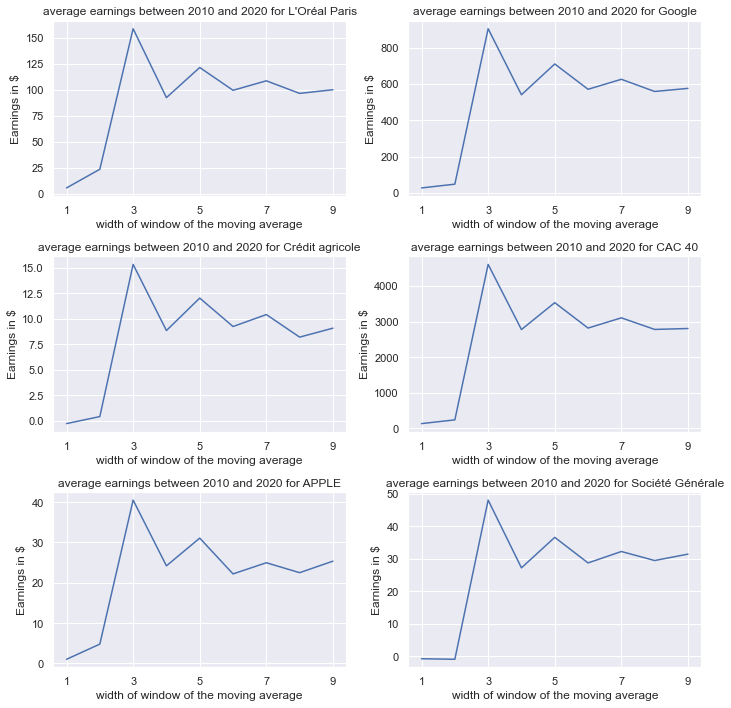

In [178]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10),constrained_layout=False)
axes = ax.flatten()
i=0
for comp in df.index:
    df.loc[comp].plot(title = "average earnings between 2010 and 2020 for "+str(comp), ylabel = "Earnings in $", xlabel = "width of window of the moving average", ax=axes[i])
    i+=1
    
plt.tight_layout()
plt.show()

Il apparait qu'en dehors de leur échelle, l'évolution des profits en fonction de largeur de la fenêtre est similaire sur l'ensemble des entreprises. Cela peut s'expliquer par le fait que la stratégie appliquée est très générale et n'optimise pas une action donnée.

Il semble donc que pour une largeur de fenêtre de 3 jours, les profits soient maximisés.


Pour que la target soit convenable, il faut aussi qu'il y ait suffisamment de transaction sur un échantillon donné. Comme la fenêtre est à 3 jours, on s'attend à en avoir suffisament.

Il convient tout de même de vérifier :

In [6]:
print("The proportion of active time is "+ str(stock[stock["strat"]!=0]["Open"].count()/stock["Open"].count()))

The proportion of active time is 0.5058365758754864


La proportion étant d'environ 1 sur 2, il nous suffira simplement d'entrainer le modèle sur un dataset suffisamment grand puisque la target sera visiblement suffisament non nulle.

## II. Sélection des features

In [703]:
from finta import TA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

Si la création de la target s'est faite en utilisant les données du futur en centrant les moyennes mobiles autour de l'instant t, nous veillons à ce que ce ne soit pas le cas pour les features.

Comme la prédiction ne prends pas nécessairement en compte la necessité d'un alternance achat-vente, il nous faut proposer une fonction qui "nettoie" la prédiction afin qu'elle fasse sens dans la pratique. 

In [447]:
def pred_cleaner(strat,rank=0):
    i,j,r=0,0,0
    output = strat
    while strat[i]!=-1 and r==rank : 
        output[i]=0
        i+=1
        if strat[i]==-1 : r+=1
    last_action = strat[i]
    i+=1
    while i<len(strat):
        if last_action == -1 and strat[i]==-1:
            output[i]=0
        elif last_action==1 and strat[i]==1:
            output[i]=0
        elif strat[i]!=0 : last_action =strat[i]
        i+=1
    while strat[-j]!=1 :
        output[-j]=0
        j+=1
        
    return(output)

Pour chaque période étudiée, il est nécessaire d'avoir une target qui commence par un achat, c'est pourquoi on applique la stratégie aux données qui donneront X_train et y_train, puis une seconde fois à celle qui donneront X_test et y_test.

Nous créeons de nouvelles variables dont la valeur est  $X_{t} - X_{t-i}$ pour i allant de 0 à lagmax qui est un paramêtre que nous chercherons à optimiser.


In [737]:
def import_data(lagmax, stock_name= "GOOGL",start = "2015", train_start="2016", train_end="2017", test_start="2018", test_end="2019"):

    assert start<train_start,"Start doit être avant train_start d'au moins lagmax jours"
    assert train_end<test_start, "Le début de la période de test chevauche la période d'entrainement"
    assert train_start<train_end and test_start<test_end, "Erreur de chronologie"

    stock = pd.DataFrame(yf.Ticker(stock_name).history(period="max"))
    stock = stock[start:test_end]

    indicateurs = {"bb width" : TA.BBWIDTH(stock), "RSI" : TA.RSI(stock), "EMA" : TA.EMA(stock), "ROC" : TA.ROC(stock), "ADX" : TA.ADX(stock)}

    cols =[]
    for i in range(1,lagmax+1):
        for key in indicateurs.keys() :
            col =  key + str(i)
            stock[col] = indicateurs[key] - indicateurs[key].shift(i)
            cols.append(col)
        stock["Open" +str(i)] = stock["Open"]-stock["Open"].shift(i)
        cols.append("Open" +str(i))


    stock_s = apply_strategy(stock[train_start:train_end])

    X_train,y_train = stock_s[cols], stock_s["strat"]

    stock_test = apply_strategy(stock[test_start:test_end])

    X_test,y_test = stock_test[cols], stock_test["strat"]
    return X_test,y_test,X_train,y_train

X_test,y_test,X_train,y_train = import_data(lagmax = 4)


## III. Implémentation d'un modèle
### III.1 Premier essai

Pour faciliter l'optimisation des modèles, on configure une pipeline et pour gagner du temps de convergence, on standardise les valeurs de chaques variables.

Comme on possède un grand nombre de variable, on applique aussi un algorithme d'élimination récursive de feature optimisé pour les forêts aléatoires.

Nous avons choisi comme une forêt aléatoire comme algorithme de classificaton puisqu'il applique une technique de bagging. En effet, enregroupant les prédictions d'arbres de décisions entrainés sur des échantillons aléatoires de X_train, diversifiés grâce au bootstrapping, on parvient à génerer un estimateur qui a plus souvent raison. 

In [727]:
pipe = make_pipeline(StandardScaler(),RFECV(RandomForestClassifier(), step = 2, min_features_to_select = 5),RandomForestClassifier())
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7753479125248509


Regardons de quelle façon l'algorithme se trompe

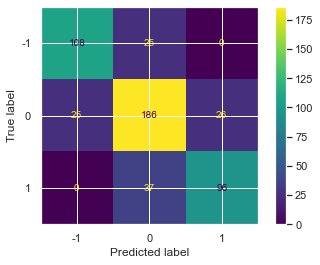

In [728]:
cm = confusion_matrix(y_test, y_pred, labels = [-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [-1, 0, 1])
disp.plot()

Le résultat n'est pas surprenant. En effet, les signaux qui indiquent un signal d'achat sont distincts de ceux d'un signal de vente, ainsi l'algorithme ne les confond pas.

L'enjeu semble donc de ne pas prédire trop de 0 et donc de manquer des signaux mais aussi de ne pas trouver des signaux fantômes.

## III.2 Optimisation des paramètres

Regardons d'abord quelle valeur de lag nous permet de faire les meilleurs prédictions

In [718]:
pipe = make_pipeline(StandardScaler(),RFECV(RandomForestClassifier(), step = 2, min_features_to_select = 5),RandomForestClassifier()))
scores=[]
l = range(1,21, 3)
for lagmax in tqdm(l):
    X_test,y_test,X_train,y_train = import_data(lagmax = lagmax)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

100%|██████████| 7/7 [03:31<00:00, 30.28s/it]


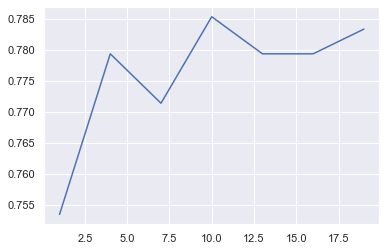

In [719]:
plt.plot(l,scores)

Un lagmax de 10 semble un bon compromis.

Maintenant, regardons les autres paramètres, propres aux estimateurs et transformers. Pour ce faire nous allons faire tourner un grid search avec cross-validation sur les paramètres qui nous semblent pertinents

In [699]:
pipe = make_pipeline(StandardScaler(),RFECV(RandomForestClassifier(), step = 2, min_features_to_select = 5),RandomForestClassifier())


params = { "randomforestclassifier__ccp_alpha" : [i/10 for i in range(10)],
         'randomforestclassifier__n_estimators' : [100+i for i in range(0,100,25)]}

grid = GridSearchCV(pipe, param_grid=params, cv=4)
grid.fit(X_train,y_train)
grid.best_params_

On obtient n_estimators = 150 pour lagmax=4. Il est fort à parier que ces deux paramètres sont corrolés. Il nous faudrait donc les utiliser en même temps, ce qui appelle à la création d'un transformer. Nous le ferons donc plus tard.

Le paramètre $\alpha$  est quant à lui optimal lorsqu'il est nul , ce qui est sa valeur par défaut.

Accuracy: 0.7733598409542743


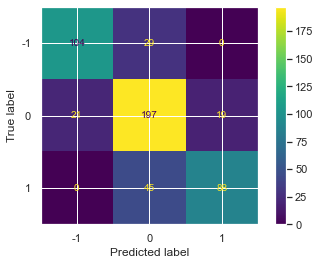

In [738]:
X_test,y_test,X_train,y_train = import_data(lagmax = 10)

pipe = make_pipeline(StandardScaler(),RFECV(RandomForestClassifier(), step = 2, min_features_to_select = 5),RandomForestClassifier(n_estimators = 150))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels = [-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [-1, 0, 1])
disp.plot()
